
# Neural Style Transfer with Custom Loss
This notebook implements Neural Style Transfer (NST) using a custom loss function that balances content loss, style loss, and total variation loss for improved image generation.


In [1]:

# Install dependencies (if needed)
!pip install tensorflow


In [2]:

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np


In [3]:

# Helper Functions

def load_and_preprocess_image(path, target_size=(224, 224)):
    img = load_img(path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(processed_img):
    x = processed_img.copy()
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    return np.clip(x, 0, 255).astype('uint8')

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


In [4]:

# Load pre-trained VGG19 model
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']
    content_layers = ['block5_conv2']
    selected_layers = style_layers + content_layers
    outputs = [vgg.get_layer(name).output for name in selected_layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model, style_layers, content_layers


In [5]:

# Loss functions
def compute_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def compute_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

def total_variation_loss(img):
    return tf.image.total_variation(img)


In [6]:

# Neural Style Transfer Class
class NeuralStyleTransfer:
    def __init__(self, content_path, style_path, style_weight=1e-2, content_weight=1e3, tv_weight=30):
        self.content_image = load_and_preprocess_image(content_path)
        self.style_image = load_and_preprocess_image(style_path)
        self.model, self.style_layers, self.content_layers = get_model()
        self.style_weight = style_weight
        self.content_weight = content_weight
        self.tv_weight = tv_weight
        self.style_targets = self.get_style_targets()
        self.content_targets = self.get_content_targets()

    def get_style_targets(self):
        style_outputs = self.model(self.style_image)
        style_outputs = style_outputs[:len(self.style_layers)]
        return [gram_matrix(style_output) for style_output in style_outputs]

    def get_content_targets(self):
        content_outputs = self.model(self.content_image)
        content_outputs = content_outputs[len(self.style_layers):]
        return content_outputs

    def compute_losses(self, generated_image):
        outputs = self.model(generated_image)
        style_outputs = outputs[:len(self.style_layers)]
        content_outputs = outputs[len(self.style_layers):]

        style_loss = 0
        content_loss = 0

        # Style loss
        for style_output, style_target in zip(style_outputs, self.style_targets):
            style_loss += compute_style_loss(style_output, style_target)

        # Content loss
        for content_output, content_target in zip(content_outputs, self.content_targets):
            content_loss += compute_content_loss(content_output, content_target)

        # Total variation loss
        total_variation = total_variation_loss(generated_image)

        # Weighted total loss
        total_loss = (self.style_weight * style_loss +
                      self.content_weight * content_loss +
                      self.tv_weight * total_variation)
        return total_loss


In [7]:

# Optimizer
def train_step(nst, generated_image, optimizer):
    with tf.GradientTape() as tape:
        loss = nst.compute_losses(generated_image)
    gradients = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    return loss


In [8]:

# Training loop
def train_neural_style_transfer(content_path, style_path, epochs=1000, lr=0.02):
    nst = NeuralStyleTransfer(content_path, style_path)
    generated_image = tf.Variable(load_and_preprocess_image(content_path))

    optimizer = tf.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        loss = train_step(nst, generated_image, optimizer)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.numpy()}')

    return generated_image


In [9]:

# Run Style Transfer
content_path = r"C:\Users\danda\OneDrive\Desktop\Wallpapers\Evening.jpg"
style_path = r"C:\Users\danda\OneDrive\Desktop\Wallpapers\Colors.jpg"
generated_image = train_neural_style_transfer(content_path, style_path)

# Save the generated image
generated_image_deprocessed = deprocess_image(generated_image.numpy()[0])
tf.keras.preprocessing.image.save_img('generated_image.jpg', generated_image_deprocessed)


Epoch 0, Loss: [8.097351e+09]
Epoch 100, Loss: [6.790778e+09]
Epoch 200, Loss: [5.565077e+09]
Epoch 300, Loss: [4.484384e+09]
Epoch 400, Loss: [3.5879532e+09]
Epoch 500, Loss: [2.8872852e+09]
Epoch 600, Loss: [2.3568404e+09]
Epoch 700, Loss: [1.9540415e+09]
Epoch 800, Loss: [1.6444028e+09]
Epoch 900, Loss: [1.4007724e+09]


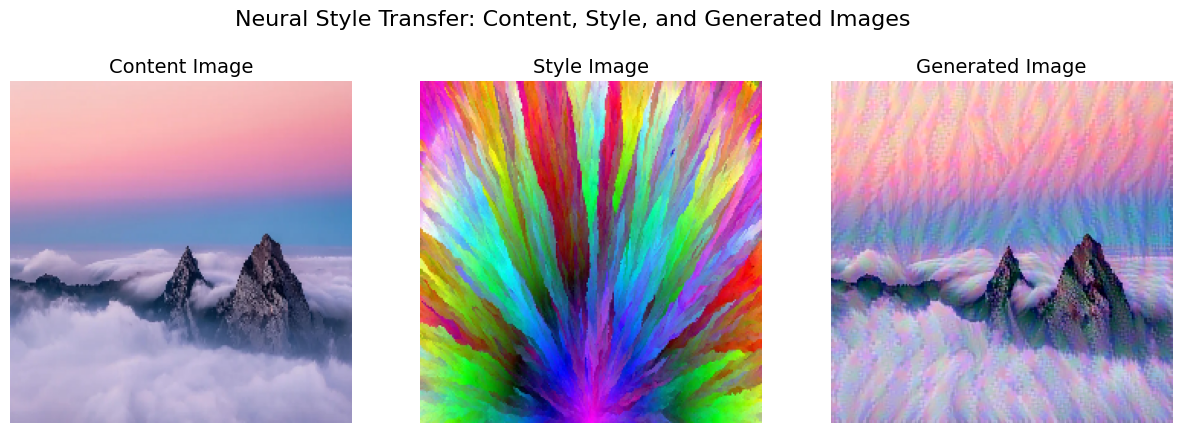

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load content and style images
content_image = load_and_preprocess_image(content_path)
style_image = load_and_preprocess_image(style_path)

# Deprocess content and style images for display (remove .numpy() call)
content_image_deprocessed = deprocess_image(content_image[0])
style_image_deprocessed = deprocess_image(style_image[0])

# Set up subplots to display content, style, and generated images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Display content image
ax[0].imshow(content_image_deprocessed)
ax[0].set_title('Content Image', fontsize=14)  # Label for content image
ax[0].axis('off')

# Display style image
ax[1].imshow(style_image_deprocessed)
ax[1].set_title('Style Image', fontsize=14)  # Label for style image
ax[1].axis('off')

# Display generated image
ax[2].imshow(generated_image_deprocessed)
ax[2].set_title('Generated Image', fontsize=14)  # Label for generated image
ax[2].axis('off')

# Add overall title for the plot
fig.suptitle('Neural Style Transfer: Content, Style, and Generated Images', fontsize=16)

# Show the plot
plt.show()
